## 利用KPCA进行异常检测

In [36]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import Model
from utils import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [37]:
# 加载测试数据

ood2label = {True: 0, False: 1}
data_test_1 = pd.read_csv('data_test_1.csv')
codes_name_1 = data_test_1['name'].to_list()
labels_test_1 = data_test_1['id'].map(lambda x: ood2label[x])
labels_test_1 = np.array(labels_test_1.to_list())

data_test_2 = pd.read_csv('data_test_2.csv')
codes_name_2 = data_test_2['name'].to_list

In [38]:
def res_testset(data_test, model_split, model_KPCA, layer_model):
    # preprocss the data
    ood2label = {True: 0, False: 1}
    name2label = {'trojan':0, 'virus':1, 'worm':2, 'backdoor':3}
    codes_name = data_test['name'].to_list()
    labels_id = data_test['id'].map(lambda x: ood2label[x])
    labels_id = np.array(labels_id.to_list())
    # 二进制文件需要分批处理，防止内存过载
    batch_size = 100
    for idx in range(0, len(codes_name), batch_size):
        code_tmp = codes_loader(codes_name[idx: idx+batch_size])
        # layer_model = Model(inputs=model_split.input, outputs=model_split.layers[8].output)
        feature_tmp = layer_model.predict(code_tmp)
        test_scores_tmp = model_KPCA.decision_function(feature_tmp)
        test_scores = test_scores_tmp if idx == 0 else np.concatenate((test_scores, test_scores_tmp), axis=0)  
    print(f"type(test_score): {type(test_scores)}")
    print(test_scores)
    fpr, tpr, thresholds = metrics.roc_curve(labels_id, test_scores)
    roc_auc = metrics.auc(fpr, tpr)
    print(f"roc_auc: {roc_auc}")

    print("histgram of test_scores from kPCA")
    scores_pd = pd.Series(test_scores)
    scores_pd.hist(bins=100)

    # plt roc curve and determine the threshold by youden index
    index = np.argmax(tpr-fpr)
    score = thresholds[index]
    print(f"threshold: {score}")
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot(color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot(fpr[index], tpr[index], marker='o', color='r')
    plt.text(fpr[index], tpr[index], f"Threshold: {score:.4f}")
    plt.show()
    
    # 剔除异常样本后的检测效果
    for idx in range(len(test_scores)):
        if test_scores[idx] < score:
            data_test.at[idx, 'novelty'] = 0 # 正常样本
        else:
            data_test.at[idx, 'novelty'] = 1 # 异常样本

    data_normal = data_test[data_test['novelty'] == 0]
    print(f"data_normal_shape: {data_normal.shape}")
    
    from sklearn.metrics import classification_report

    codes_name = data_normal['name'].to_list()
    label_normal = data_normal['label'].map(lambda x: name2label[x])
    label_normal = np.array(label_normal).reshape(-1, 1)
    # label_normal = np.array(label_normal.to_list())

    batch_size = 100
    for idx in range(0, len(codes_name), batch_size):
        code_tmp = codes_loader(codes_name[idx: idx+batch_size])
        pre_tmp = model_split.predict(code_tmp)
        pre_tmp = np.argmax(pre_tmp, axis=1)
        # if idx == 0:
        #     print(pre_tmp)
        y_pred = pre_tmp if idx == 0 else np.concatenate((y_pred, pre_tmp), axis=0)     

    target_names = {'trojan', 'virus', 'worm', 'backdoor'}
    print(classification_report(label_normal, y_pred, target_names=target_names, digits=4))

    # 异常检测报告
    print("异常检测报告")
    two_pred = np.array(data_test['novelty'])
    two_pred = two_pred.astype('int64')
    ood2label = {True: 0, False: 1}
    label_id = np.array(data_test['id'].map(lambda x: ood2label[x]))
    print(classification_report(label_id, two_pred, digits=4))


In [39]:
data_test_1 = pd.read_csv("data_test_1.csv")
data_test_2 = pd.read_csv("data_test_2.csv")

type(test_score): <class 'numpy.ndarray'>
[ 6.71542773e-01 -4.72898702e-04 -9.06894410e-05 ... -3.40801222e-03
 -2.99379266e-03  2.01683023e-01]
roc_auc: 0.9573108051368922
histgram of test_scores from kPCA
threshold: 0.20565154340175695


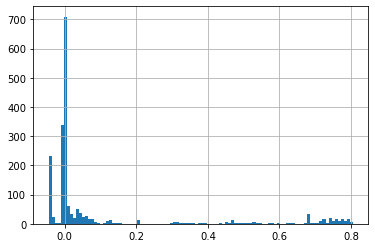

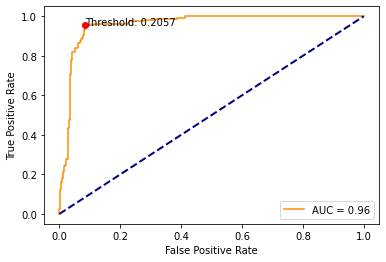

data_normal_shape: (1651, 12)
              precision    recall  f1-score   support

       virus     0.9875    1.0000    0.9937       555
        worm     1.0000    0.9981    0.9991       528
    backdoor     1.0000    0.9857    0.9928       280
      trojan     1.0000    0.9931    0.9965       288

    accuracy                         0.9958      1651
   macro avg     0.9969    0.9942    0.9955      1651
weighted avg     0.9958    0.9958    0.9958      1651

异常检测报告
              precision    recall  f1-score   support

           0     0.9958    0.9164    0.9544      1794
           1     0.4949    0.9545    0.6519       154

    accuracy                         0.9194      1948
   macro avg     0.7454    0.9355    0.8032      1948
weighted avg     0.9562    0.9194    0.9305      1948

type(test_score): <class 'numpy.ndarray'>
[-0.00308847  0.27425616  0.75719714 ...  0.00807334 -0.00828515
  0.27000449]
roc_auc: 0.9210614255479784
histgram of test_scores from kPCA
threshold: 0.31872

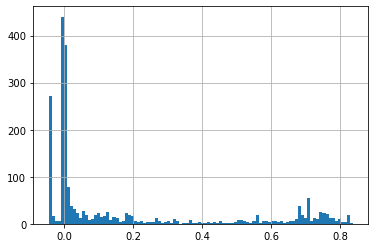

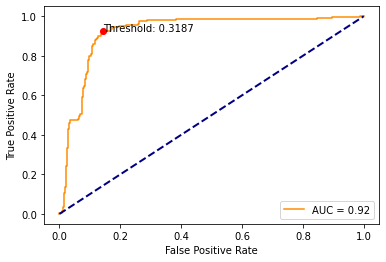

data_normal_shape: (1628, 11)
              precision    recall  f1-score   support

       virus     0.9836    0.9905    0.9870       423
        worm     0.9941    0.9883    0.9912       514
    backdoor     0.9919    1.0000    0.9959       368
      trojan     0.9906    0.9814    0.9860       323

    accuracy                         0.9902      1628
   macro avg     0.9901    0.9901    0.9901      1628
weighted avg     0.9902    0.9902    0.9902      1628

异常检测报告
              precision    recall  f1-score   support

           0     0.9902    0.8579    0.9193      1879
           1     0.4270    0.9256    0.5844       215

    accuracy                         0.8649      2094
   macro avg     0.7086    0.8917    0.7519      2094
weighted avg     0.9324    0.8649    0.8849      2094



In [40]:
from methods.kpca import kPCA
from sklearn import metrics

# 取模型输出层的前一层作为特征提取器
model_split = keras.models.load_model("../model/malconv_split.h5")
layer_model = Model(inputs=model_split.input, outputs=model_split.layers[8].output)
feature_train = np.load('feature_train.npy')
model_KPCA = kPCA(q = 64, sigma = 1.0985)
model_KPCA.fit(feature_train)

res_testset(data_test_1, model_split, model_KPCA, layer_model)
res_testset(data_test_2, model_split, model_KPCA, layer_model)

100%|██████████| 29/29 [00:01<00:00, 22.08it/s]


type(test_score): <class 'numpy.ndarray'>
[1.00109877 0.14567653 0.11966679 ... 0.99744317 0.74485655 1.00109877]
roc_auc: 0.9474492898405942
histgram of test_scores from kPCA
threshold: 1.0010987740211974


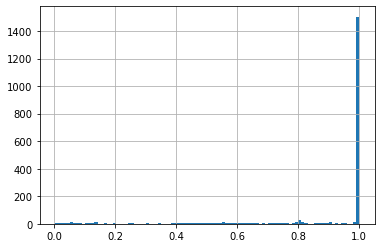

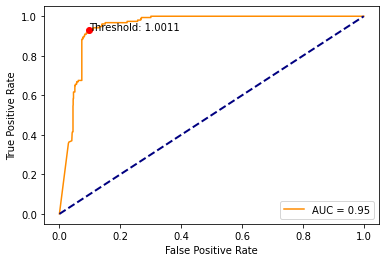

data_normal_shape: (1630, 12)
              precision    recall  f1-score   support

       virus     0.9799    1.0000    0.9899       537
        worm     1.0000    0.9981    0.9990       523
    backdoor     1.0000    0.9689    0.9842       289
      trojan     1.0000    0.9964    0.9982       281

    accuracy                         0.9933      1630
   macro avg     0.9950    0.9908    0.9928      1630
weighted avg     0.9934    0.9933    0.9932      1630

异常检测报告
              precision    recall  f1-score   support

           0     0.9933    0.9025    0.9457      1794
           1     0.4497    0.9286    0.6059       154

    accuracy                         0.9045      1948
   macro avg     0.7215    0.9155    0.7758      1948
weighted avg     0.9503    0.9045    0.9188      1948

type(test_score): <class 'numpy.ndarray'>
[1.00103202 1.00109785 1.00109877 ... 1.00108997 1.00097804 1.00109877]
roc_auc: 0.8975655036696907
histgram of test_scores from kPCA
threshold: 1.001098774038

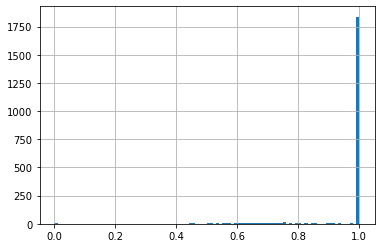

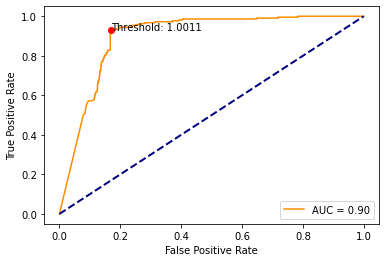

data_normal_shape: (1576, 11)
              precision    recall  f1-score   support

       virus     0.9871    0.9896    0.9884       386
        worm     0.9941    0.9844    0.9892       512
    backdoor     0.9892    1.0000    0.9946       366
      trojan     0.9904    0.9904    0.9904       312

    accuracy                         0.9905      1576
   macro avg     0.9902    0.9911    0.9906      1576
weighted avg     0.9905    0.9905    0.9905      1576

异常检测报告
              precision    recall  f1-score   support

           0     0.9905    0.8308    0.9036      1879
           1     0.3861    0.9302    0.5457       215

    accuracy                         0.8410      2094
   macro avg     0.6883    0.8805    0.7247      2094
weighted avg     0.9284    0.8410    0.8669      2094



In [46]:
data_train = pd.read_csv("data_train.csv")

# 取模型全连接前的一层作为特征提取器
model_split = keras.models.load_model("../model/malconv_split.h5")
layer_model = Model(inputs=model_split.input, outputs=model_split.layers[7].output)

data_path_train, labels_train = path_loader(data_train)
# 分批预测，防止内存过载
batch_size = 100
for idx in range(0, len(data_train), batch_size):
    codes_tmp, labels_tmp = train_data_loader(data_path_train[idx:idx+batch_size], labels_train[idx:idx+batch_size])
    feature_tmp = layer_model.predict(codes_tmp)
    feature_train = feature_tmp if idx == 0 else np.concatenate((feature_train, feature_tmp), axis=0)

model_KPCA = kPCA(q = 64, sigma = 1.0985)
model_KPCA.fit(feature_train)

res_testset(data_test_1, model_split, model_KPCA, layer_model)
res_testset(data_test_2, model_split, model_KPCA, layer_model)